In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import soundfile
import librosa
import matplotlib.pyplot as plt

In [12]:
# Load the models
audio_model = tf.keras.models.load_model('C://Users//uday//OneDrive//Desktop//EMR//Fuse//Models//Emotion_Voice_Detection_Model1.h5')
face_model = tf.keras.models.load_model('C://Users//uday//OneDrive//Desktop//EMR//Fuse//Models//face_cnn9.h5')

c:\Users\uday\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\uday\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
# Emotion labels
emotions = ['Neutral', 'Happy', 'Sad', 'Angry']

# Function to get predictions from each model
def get_emotion_probabilities(face_input, audio_input):
    face_probs = face_model.predict(face_input)
    audio_probs = audio_model.predict(audio_input)
    return face_probs, audio_probs

# Dynamic weight adjustment based on confidence
def dynamic_weight_adjustment(face_probs, audio_probs):
    face_confidence = np.max(face_probs)
    audio_confidence = np.max(audio_probs)
    total_confidence = face_confidence + audio_confidence
    face_weight = face_confidence / total_confidence
    audio_weight = audio_confidence / total_confidence
    return face_weight, audio_weight

# Weighted emotion prediction with confidence thresholding
def weighted_emotion_prediction(face_probs, audio_probs, threshold=0.5):
    # Adjust weights based on confidence levels
    face_weight, audio_weight = dynamic_weight_adjustment(face_probs, audio_probs)
    
    # Weighted sum of probabilities
    final_probs = face_weight * face_probs + audio_weight * audio_probs
    
    # Apply confidence thresholding
    if np.max(final_probs) < threshold:
        return "Neutral", final_probs  # Default to "Neutral" if below threshold
    else:
        final_emotion_index = np.argmax(final_probs)
        return emotions[final_emotion_index], final_probs

In [14]:
# Function to preprocess the face image
def preprocess_image(image_path, target_size=(128, 128)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize
    return img_array

# Function to extract MFCC features from the audio file
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc", True)
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if X.ndim >= 2:
            X = np.mean(X, 1)
        sample_rate = sound_file.samplerate
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
    return result


In [15]:
# Plotting function for output presentation
def plot_emotion_probabilities(probs, title="Emotion Probabilities"):
    plt.bar(emotions, probs[0])
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Probability")
    plt.show()

# Prepare the inputs
image_path = 'C://Users//uday//OneDrive//Desktop//EMR//Fuse//testImages//angry.jpg' 
audio_path = "C://Users//uday//OneDrive//Desktop//EMR//EMR//Data//Actor_01//03-02-05-02-01-01-01.wav"

# Preprocess the face image
face_input = preprocess_image(image_path)

# Extract MFCC features from the audio file
mfcc_features = extract_feature(audio_path)
audio_input = np.expand_dims(mfcc_features, axis=0)

# Get emotion probabilities from each model
face_probs, audio_probs = get_emotion_probabilities(face_input, audio_input)

print("Face Model Prediction Probabilities:", face_probs)
print("Audio Model Prediction Probabilities:", audio_probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Face Model Prediction Probabilities: [[0.581932   0.00403051 0.01029277 0.40374476]]
Audio Model Prediction Probabilities: [[9.9872380e-01 1.2676666e-03 8.3777185e-10 8.4695639e-06]]


In [16]:
# Check which emotion each model is predicting
face_predicted_emotion = emotions[np.argmax(face_probs)]
audio_predicted_emotion = emotions[np.argmax(audio_probs)]
print(f"Face Model Predicted Emotion: {face_predicted_emotion}")
print(f"Audio Model Predicted Emotion: {audio_predicted_emotion}")

Face Model Predicted Emotion: Neutral
Audio Model Predicted Emotion: Neutral


In [17]:
# Perform weighted prediction and apply confidence thresholding
predicted_emotion, final_probs = weighted_emotion_prediction(face_probs, audio_probs)

# Print the final result
print("Predicted Emotion:", predicted_emotion)
print("Final Probabilities:", final_probs)

Predicted Emotion: Neutral
Final Probabilities: [[0.8452784  0.00228483 0.00378937 0.14864744]]


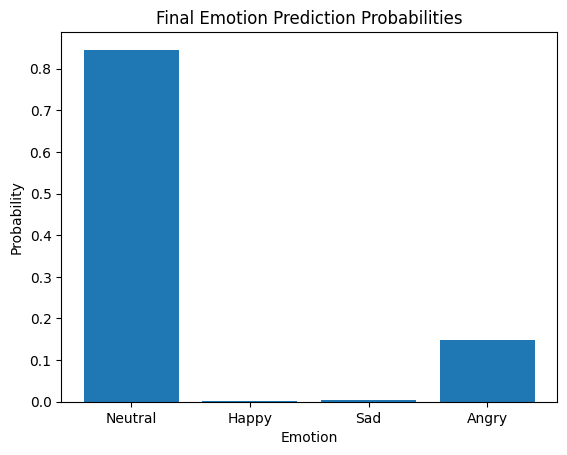

In [18]:
 # Display the final probabilities in a bar chart
plot_emotion_probabilities(final_probs, title="Final Emotion Prediction Probabilities")